In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

##  Importing Data
- From observation the data is on a monthly scale beginning at 1972-1-1 
- from the plot below we can see there is seasonality in frozen desserts production over time 
- The goal will be to create a model that will attempt to predict this seasonality. 

In [5]:
frozen = pd.read_csv("resources/Frozen_Dessert_Production.csv", parse_dates = True, index_col="DATE")

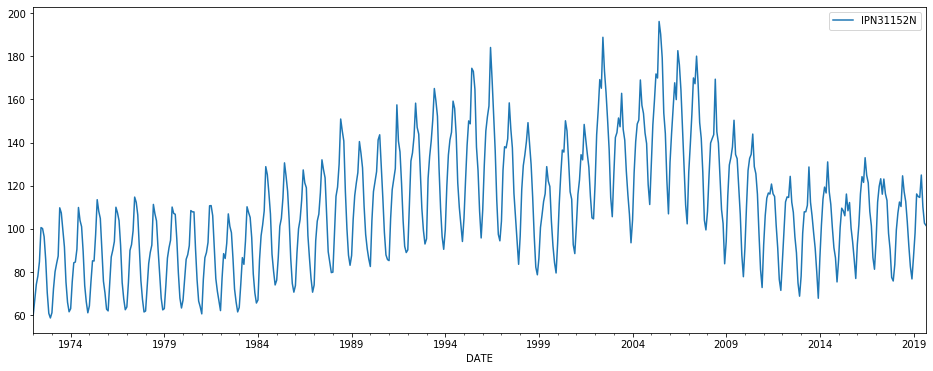

In [9]:
frozen.plot(figsize = (16,6));

### Training and testing the data 
- For this model 24 months will be a good sample to use for testing 
- will scale the data for this model as well 

In [10]:
test_sample = 24
test_index = len(frozen) - test_sample

In [11]:
test_index

549

In [12]:
len(frozen)

573

In [15]:
train = frozen.iloc[:test_index]

In [16]:
test = frozen.iloc[test_index:]

In [17]:
train.shape

(549, 1)

In [18]:
test.shape

(24, 1)

## Scaling the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scalar = MinMaxScaler()

In [19]:
train_scaled = scalar.fit_transform(train)

In [20]:
test_scaled = scalar.transform(test)

## Batch time series generator
- For the generator we will use a length of 12(one year) to train our model
- This should give a good amount of patterns to the model to make predictions

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 12
generator = TimeseriesGenerator(train_scaled,train_scaled, length=length, batch_size=1)

## Generator Observation

In [23]:
X,y = generator[0]

In [24]:
X

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972],
        [0.30154406],
        [0.27416065],
        [0.19736841],
        [0.08532665],
        [0.01561588],
        [0.        ]]])

In [25]:
y

array([[0.01774221]])

### Evaluating Generator
- we can see that the 12th point is accurate, making the generator fitting for our model

In [29]:
train_scaled[12]

array([0.01774221])

### validation generator 
- To mske sure we have data to compare our model training to we will use a validation generator containing the test data to compare our training loss to
- This also allows us to set an early stopping callback so we do not overtrain
- Will also creat a tensor board object to get visualization on the model training proecess and architecture

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [31]:
stop = EarlyStopping(monitor="val_loss", mode="min", patience=2)

In [32]:
pwd

'/Users/berkatbhatti/Desktop/Python/Portfolio/Recurrent Neural Networks/Forecasting Frozen Deserts Sales using Recurrent Neural Networks'

In [33]:
board_file_dir = "board/logs/fit"
board = TensorBoard(log_dir= board_file_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=2,
    embeddings_freq=0,
    embeddings_metadata=None,)

### validation Generator

In [34]:
val_gen = TimeseriesGenerator(test_scaled,test_scaled, length= length, batch_size=1)

### Model Creation
- not that we have all we need to create the model we will create here
- WE wll use an LSTM model to vanishing gradient 

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [36]:
n_features = 1

In [37]:
model = Sequential()
model.add(LSTM(units = 100, activation = "relu", input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimization = "adam", loss = "mse")

### Fitting Model

In [38]:
model.fit_generator(generator=generator, validation_data=val_gen, epochs=20, callbacks=[stop, board])

Epoch 1/20
537/537 [==============================] - 585s 1s/step - loss: 0.0204 - val_loss: 0.0087
Epoch 2/20
537/537 [==============================] - 576s 1s/step - loss: 0.0094 - val_loss: 0.0055
Epoch 3/20
537/537 [==============================] - 623s 1s/step - loss: 0.0066 - val_loss: 0.0091
Epoch 4/20
537/537 [==============================] - 506s 941ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 5/20
537/537 [==============================] - 524s 976ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 6/20
537/537 [==============================] - 445s 829ms/step - loss: 0.0038 - val_loss: 0.0043


## - Model Performance
- Looks like the training for thie data went well and both the training and validaton data decresed in error over the 6 epoch before stoppage

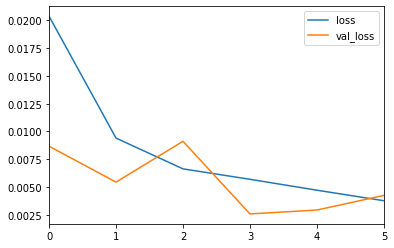

In [40]:
pd.DataFrame(model.history.history).plot()

## Model Predictions

In [41]:
test_predictions = []
batch = test_scaled[-length:]
current_batch = batch.reshape((1,length,n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [42]:
test_predictions

[array([0.17043781], dtype=float32),
 array([0.11045834], dtype=float32),
 array([0.09322307], dtype=float32),
 array([0.13099815], dtype=float32),
 array([0.2043596], dtype=float32),
 array([0.27531862], dtype=float32),
 array([0.31990746], dtype=float32),
 array([0.350581], dtype=float32),
 array([0.35733914], dtype=float32),
 array([0.32206154], dtype=float32),
 array([0.2611342], dtype=float32),
 array([0.17162527], dtype=float32),
 array([0.08187518], dtype=float32),
 array([0.03619478], dtype=float32),
 array([0.03011958], dtype=float32),
 array([0.06167174], dtype=float32),
 array([0.12103361], dtype=float32),
 array([0.18901111], dtype=float32),
 array([0.24385895], dtype=float32),
 array([0.27953285], dtype=float32),
 array([0.2893771], dtype=float32),
 array([0.2661676], dtype=float32),
 array([0.19749875], dtype=float32),
 array([0.11406781], dtype=float32)]

## True predicitions
- inverse scale

In [44]:
true_tred = scalar.inverse_transform(test_predictions)

In [45]:
true_tred

array([[ 82.09736835],
       [ 73.8493577 ],
       [ 71.47926726],
       [ 76.67386643],
       [ 86.76208641],
       [ 96.51993753],
       [102.651522  ],
       [106.86955924],
       [107.79889928],
       [102.94773823],
       [ 94.56938326],
       [ 82.26066041],
       [ 69.91877568],
       [ 63.63708522],
       [ 62.80166133],
       [ 67.14052167],
       [ 75.30360359],
       [ 84.65145513],
       [ 92.19379504],
       [ 97.09945235],
       [ 98.45317267],
       [ 95.26154623],
       [ 85.81862386],
       [ 74.34570911]])

### Plot of test and test pred
- Appears that our model picked up the patters of the frozen Deserts basedo on a 12 month period while training on 2 years of data

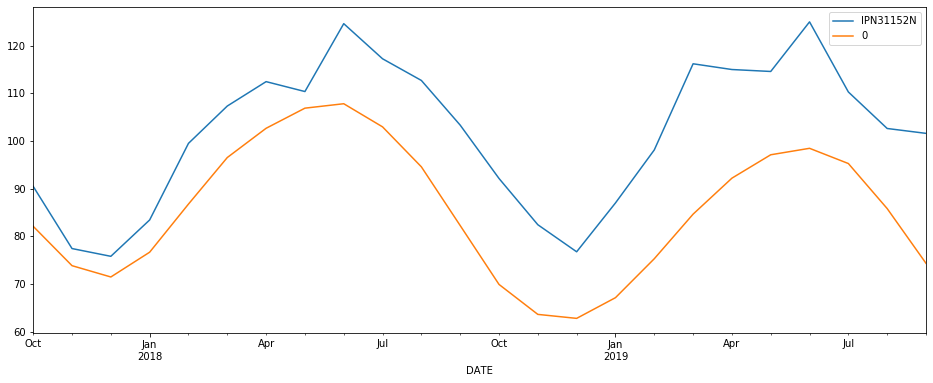

In [50]:
ax = test.plot(figsize = (16,6))
pd.DataFrame(true_tred, index=test.index).plot(ax = ax)